In [1]:
%matplotlib inline

For this project, we wanted to determine the amount of "blobs" per cells in different conditions.

The first problem was to work with different image formats (coming from different collaborators), for that I mostly used Python-bioformats package. I also wanted to visualize all the images at once to judge their quality and then perform the analysis in batch. 
I then wrote few functions located in the module [open_image_bioformat](https://github.com/cespenel/Analyse_blob/blob/master/Find_spot_Ecad_Fotine/scripts/open_image_bioformat.py):
 - read_bioformat: Read images in almost any format
 - batch_analysis_bioformat: Read all the images of a folder and create a list
 - Show_serie_all: Show all the images of the folder 
 - ...
 
Then for the analysis of the amount of blobs per cell, I essentially work with scikit-image and pandas. The functions that I wrote are located in the module [scripts_spot_Ecad_nucleus](https://github.com/cespenel/Analyse_blob/blob/master/Find_spot_Ecad_Fotine/scripts/scripts_spot_Ecad_nucleus.py).


In [2]:
import open_image_bioformat as oib

Here is an example of 2 images:

1st channel:

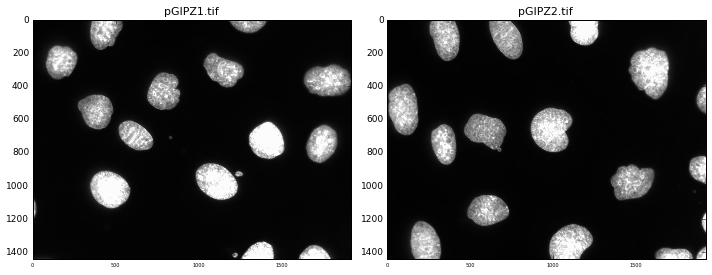

(4, 4)

In [12]:
path = "/Users/Espenel/Desktop/analysis_geri/removed/"
images, im = oib.batch_analysis_bioformat(path, imageformat = 'tif')
oib.show_series_all(images, path, im, channel = 'channel0')

2nd channel:

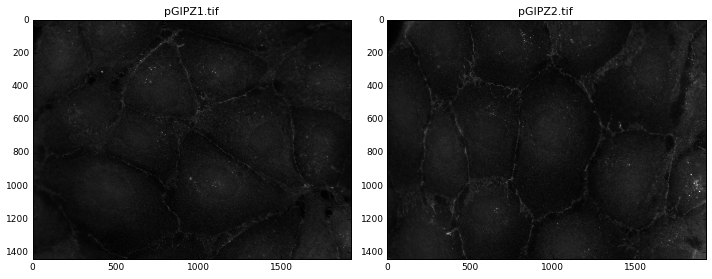

(4, 4)

In [4]:
path = "/Users/Espenel/Desktop/analysis_geri/removed/"
images, im = oib.batch_analysis_bioformat(path, imageformat = 'tif')
oib.show_series_all(images, path, im, channel = 'channel1')

Let's have a look at the histograms in channel 1:

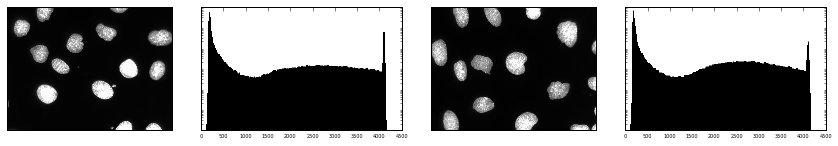

(8, 4)

In [5]:
path = "/Users/Espenel/Desktop/analysis_geri/removed/"
images, im = oib.batch_analysis_bioformat(path, imageformat = 'tif')
oib.show_series_all_histo(images, im)

We can see from the histogram that the full 12 bits dynamic range is occupied. However, the much higher peak at the maximum value tells us that some of the signal is saturated.
This is not great, but I can still proceed to find and count the nucleus in the images to determine the number of cells. For that I use the module scripts_spot_Ecad_nucleus, here is an example with the first image of the list:

14

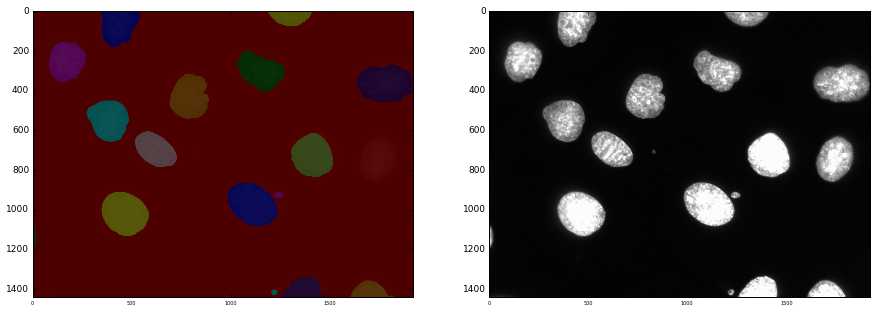

In [6]:
import blobs_per_cell as bpc
bpc.number_nucleus(images[0][:,:,0])

14 Cells, note that eventhough some small object are segmented, I didn't count them. 
The next step is to find the amound of blobs per cells.

First we start by looking at the histogram:

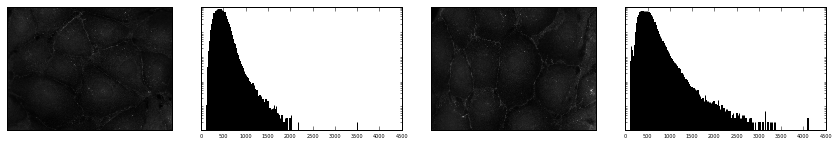

(8, 4)

In [7]:
oib.show_series_all_histo(images, im, channel = 'channel1')

I first try to find the blobs in the image using the difference of Gaussian function in scikit_image and using an Otsu threshold. 

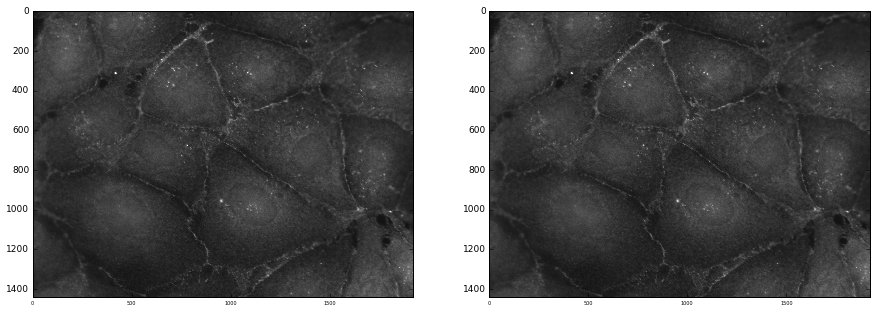

In [8]:
blobs = bpc.blobs(images[1][:,:,0])
bpc.show_result(blobs, images[0][:,:,1])

I try to highlight the blobs by using a "Laplacian" kernel followed by a gaussian filter:

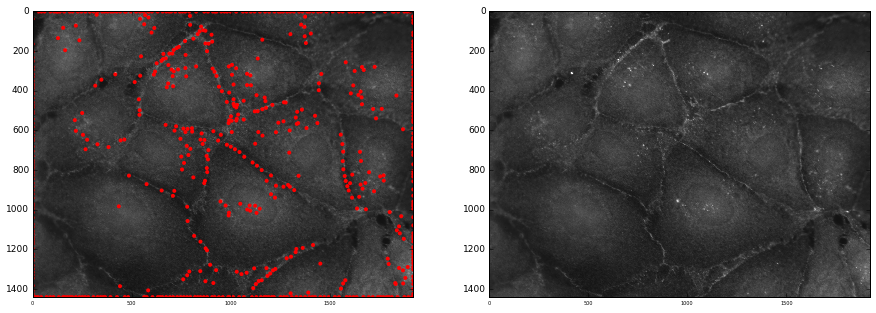

In [9]:
image_conv = bpc.image_processing(images[0][:,:,1])
blobs = bpc.blobs(image_conv)
bpc.show_result(blobs, images[0][:,:,1])

After this step, there is a lot of "non specific" blobs found at the interface between cells. I then applied a mask on this region:

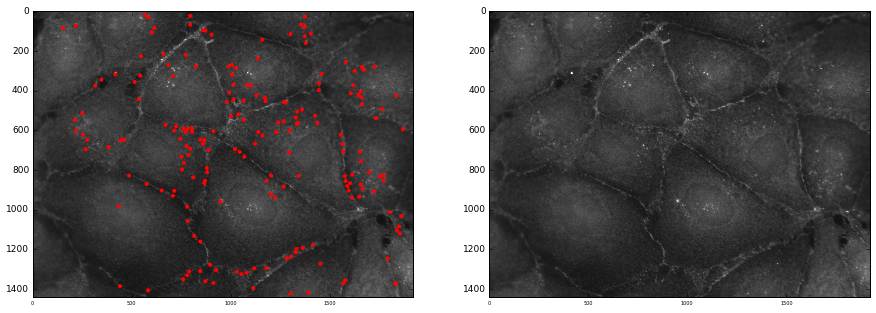

In [10]:
blobs = bpc.blobs(image_conv, remove_mb = True, val = 150, size = 450)
bpc.show_result(blobs, images[0][:,:,1])

When we are confortable with the results (it's possible to adjust the value of the threshold (val) and the size of the object that are ecluded(size)), we can do "batch experiment":

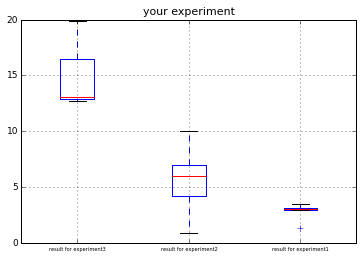

In [11]:
# %load main_blobs_per_cell_joblib.py

#!/usr/bin/python -tt

from joblib import Parallel, delayed

def main():

    path = "/Users/Espenel/Desktop/analysis_geri/Rdecma 2/folder_name/experiment1"
    path2 = "/Users/Espenel/Desktop/analysis_geri/Rdecma 2/folder_name/experiment2"
    path3 = "/Users/Espenel/Desktop/analysis_geri/Rdecma 2/folder_name/experiment3"

    path_list = [path, path2, path3]


    def analysis(path):

        images = bpc.batch_analysis(path)
        number_of_cells = Parallel(n_jobs=4)(delayed(bpc.number_nucleus)(img[0]) for img in images)
        image_conv =  Parallel(n_jobs=4)(delayed(bpc.image_processing)(img[1]) for img in images)
        blob_in_image = Parallel(n_jobs=4)(delayed(bpc.blobs)(im, remove_mb = True) for im in image_conv)

        number_blobs = [len(blob) for blob in blob_in_image]

        blobs_per_cell = [a / float(b) for a,b in zip (number_blobs, number_of_cells)]

        return blobs_per_cell

    values = [analysis(path) for path in path_list]

    bpc.plot_result(path_list, values, name_exp ='result for', title = "your experiment", save = False)


if __name__ == '__main__':
  main()

Here, I gather my codes using a main() function: 

1. I use the joblib package in order to run the function a little faster. 
2. I find the number of cells, the number of blobs and extract the number of blobs per cell.
3. In plot_result, I create DataFrame of the results using python and plot a box plot. (if save = True, I will save data in an excel file). 